# Comparing European Mortality Rates to US States
Based on Nate Silver [wondering how US States compare to European countries](https://twitter.com/NateSilver538/status/1247259557476339717).

In [19]:
import pandas as pd
pd.options.display.max_rows = 100
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_mappings import state_abbrv

In [20]:
# get cases and deaths by country
# Note that these are daily numbers, not cumulative sums
world = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')
world.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,17/09/2020,17,9,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.653446
1,16/09/2020,16,9,2020,40,10,Afghanistan,AF,AFG,38041757.0,Asia,1.708649
2,15/09/2020,15,9,2020,99,6,Afghanistan,AF,AFG,38041757.0,Asia,1.627159
3,14/09/2020,14,9,2020,75,0,Afghanistan,AF,AFG,38041757.0,Asia,1.456294
4,13/09/2020,13,9,2020,35,0,Afghanistan,AF,AFG,38041757.0,Asia,1.309088


In [21]:
# Recode 'United_Kingdom' as 'United Kingdom' for later matching
world.loc[world.geoId == 'UK','countriesAndTerritories'] = 'United Kingdom'

In [22]:
# reorganize data
world = world.groupby(['countriesAndTerritories'])\
    .agg({'cases': sum, 'deaths': sum, 'popData2019': max})
world.rename(
    columns={'countriesAndTerritories': 'country',
             'popData2019': 'population'},inplace=True)
world.head()

,cases,deaths,population
countriesAndTerritories,,,
Afghanistan,38872,1436,38041757.0
Albania,11816,343,2862427.0
Algeria,48966,1645,43053054.0
Andorra,1438,53,76177.0
Angola,3569,139,31825299.0


In [23]:
# Read in the state level cases/deaths data from the NYT
# Note that cases and deaths here are cumulative, not daily
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
states.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [24]:
states = states.groupby(['state']).agg({'cases': max, 'deaths': max})

In [25]:
# read in state populations and area
# (source: https://worldpopulationreview.com/states/states-by-area/)
state_populations = pd.read_csv('state population and area.csv')
state_populations.head()

,State,TotalArea,LandArea,WaterArea,Density,Pop
0,Alaska,665384,570641,94743,1.2863,734002
1,Texas,268596,261232,7365,112.8204,29472295
2,California,163696,155779,7916,256.3727,39937489
3,Montana,147040,145546,1494,7.4668,1086759
4,New Mexico,121590,121298,292,17.2850,2096640


In [26]:
states = states.merge(state_populations,left_index=True,right_on='State')
states.head()

,cases,deaths,State,TotalArea,LandArea,WaterArea,Density,Pop
29,141087,2392,Alabama,52420,50645,1775,96.9221,4908621
0,7308,41,Alaska,665384,570641,94743,1.2863,734002
5,209911,5376,Arizona,113990,113594,396,64.9550,7378494
28,72219,1157,Arkansas,53179,52035,1143,58.4030,3038999
2,773318,14716,California,163696,155779,7916,256.3727,39937489


In [27]:
# convert land area to square km and density to Pop/sq km
states['land area km'] = 2.58999 * states['LandArea']
states['density'] = states['Pop'] / states['land area km']
states.drop(columns=['TotalArea','LandArea','WaterArea','Density'],inplace=True)
states.rename(columns={'Pop': 'population'},inplace=True)
states['continent'] = 'na'
states.set_index('State',inplace=True)
states.head()

,cases,deaths,population,land area km,density,continent
State,,,,,,
Alabama,141087,2392,4908621,1.311700e+05,37.421814,na
Alaska,7308,41,734002,1.477954e+06,0.496634,na
Arizona,209911,5376,7378494,2.942073e+05,25.079233,na
Arkansas,72219,1157,3038999,1.347701e+05,22.549500,na
California,773318,14716,39937489,4.034661e+05,98.985996,na


In [28]:
# read in the list of countries in Europe
# this will give us many irrelevant columns but we really just want the names
# Also note that the country populations in this file are not identical to those
# in the world file so we'll ignore these
europe = pd.read_csv('https://raw.githubusercontent.com/ajturner/acetate/master/places/Countries-Europe.csv')
europe.head()

,zoom,name,abbreviation,ISO alpha 2,ISO alpha 3,ISO numeric,land area km,population,latitude,longitude,continent
0,3,Ukraine,Ukr.,UA,UKR,804,603700.0,45415596,49.0,32.0,eu
1,3,France,Fr.,FR,FRA,250,547030.0,64768389,46.0,2.0,eu
2,3,Spain,Spain,ES,ESP,724,504782.0,46505963,40.0,-4.0,eu
3,3,Sweden,Swe.,SE,SWE,752,449964.0,9045000,62.0,15.0,eu
4,3,Germany,Ger.,DE,DEU,276,357021.0,82369000,51.5,10.5,eu


In [29]:
europe = europe[['name','continent','land area km']]\
    .merge(world,left_on='name',right_index=True)\
    .set_index('name')

# compute density
europe['density'] = europe['population']/europe['land area km']
europe.head()

,continent,land area km,cases,deaths,population,density
name,,,,,,
Ukraine,eu,603700.0,162660,3340,43993643.0,72.873353
France,eu,547030.0,404888,31045,67012883.0,122.503122
Spain,eu,504782.0,614360,30243,46937060.0,92.984813
Sweden,eu,449964.0,87575,5860,10230185.0,22.735563
Germany,eu,357021.0,265857,9371,83019213.0,232.533137


In [30]:
# Merge the European data with the state data and compute ratios
europe_v_states = europe.append(states)
europe_v_states['deathsPerM'] = 1E6 * europe_v_states.deaths / europe_v_states.population
europe_v_states['casesPerK'] = 1e3 * europe_v_states['cases'] / europe_v_states['population']
europe_v_states['cfr'] = europe_v_states.deaths/europe_v_states.cases

In [31]:
# sort by descending mortality, show top 20, areas with ≥1M people
europe_v_states[europe_v_states.population >= 1E6].sort_values(by='deathsPerM',ascending=False)

,continent,land area km,cases,deaths,population,density,deathsPerM,casesPerK,cfr
New Jersey,na,19046.78646,199583,16054,8936574.0,469.190644,1796.437874,22.333279,0.080438
New York,na,122055.86874,451078,32662,19440469.0,159.275168,1680.103500,23.203041,0.072409
Massachusetts,na,20201.92200,128888,9245,6976597.0,345.343230,1325.144623,18.474336,0.071729
Connecticut,na,12540.73158,55166,4487,3563077.0,284.120346,1259.304809,15.482685,0.081336
Louisiana,na,111897.92796,159865,5294,4645184.0,41.512690,1139.674984,34.415214,0.033115
Rhode Island,na,2678.04966,23358,1081,1056161.0,394.376929,1023.518195,22.115946,0.046280
Mississippi,na,121530.10077,91234,2756,2989260.0,24.596869,921.967310,30.520597,0.030208
Belgium,eu,30510.00000,95854,9935,11455519.0,375.467683,867.267559,8.367495,0.103647
Arizona,na,294207.32406,209911,5376,7378494.0,25.079233,728.603967,28.449030,0.025611
Michigan,na,146435.44461,125782,6944,10045029.0,68.596978,691.287203,12.521816,0.055207


In [75]:
def color(s):
    if s.state in(['New Jersey','New York','Massachusetts','Connecticut','Illinois','Maryland','Rhode Island']):
        return ['color: blue' for v in s]
    elif s.state in ['Belgium','Spain','United Kingdom','Italy','Sweden']:
        return ['color: green' for v in s]
    else:
        return ['color: red' for v in s]
    
df = europe_v_states[europe_v_states.population >= 1E6]\
    .sort_values(by='deathsPerM',ascending=False)\
    .head(20)[['cases','deaths','population','deathsPerM','casesPerK']]\
    .reset_index()\
    .rename(columns={'index': 'state'})

df[['population','deathsPerM','casesPerK']] = df[['population','deathsPerM','casesPerK']].astype(int)
df.style.apply(color,axis=1)

,state,cases,deaths,population,deathsPerM,casesPerK
0,New Jersey,199583,16054,8936574,1796,22
1,New York,451078,32662,19440469,1680,23
2,Massachusetts,128888,9245,6976597,1325,18
3,Connecticut,55166,4487,3563077,1259,15
4,Louisiana,159865,5294,4645184,1139,34
5,Rhode Island,23358,1081,1056161,1023,22
6,Mississippi,91234,2756,2989260,921,30
7,Belgium,95854,9935,11455519,867,8
8,Arizona,209911,5376,7378494,728,28
9,Michigan,125782,6944,10045029,691,12


## Effect of population density

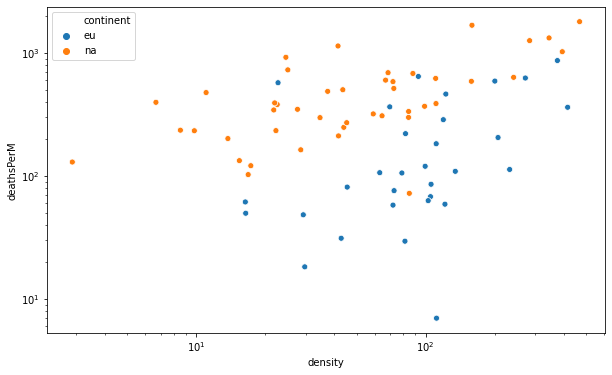

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
tmp = europe_v_states[europe_v_states.population >= 1E6]
lm = sns.scatterplot(x=tmp['density'],y=tmp['deathsPerM'],hue=tmp['continent'],ax=ax)
lm.axes.set_yscale('log')
lm.axes.set_xscale('log')

In [34]:
europe_v_states['ST'] = europe_v_states.index.map(state_abbrv)
europe_v_states.loc[europe_v_states.continent != 'na','ST'] = europe_v_states.loc[europe_v_states.continent != 'na'].index

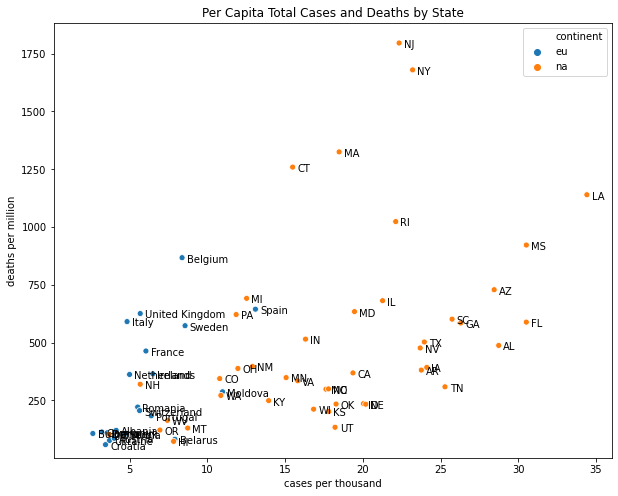

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
tmp = europe_v_states[(europe_v_states.population >= 1E6) & (europe_v_states.casesPerK > 2.5)]
p1 = sns.scatterplot(data=tmp,x='casesPerK',y='deathsPerM',hue=tmp['continent'])
ax.set_title('Per Capita Total Cases and Deaths by State')
ax.set_xlabel('cases per thousand')
ax.set_ylabel('deaths per million')
plt.ylim(1,)
plt.xlim(0.1,)

for i in range(0,tmp.shape[0]):
    ha = 'left'
    hOffset = 0.3
    #if tmp.continent[i] != 'na':
        #ha = 'right'
        #hOffset = -0.3
    p1.text(tmp['casesPerK'][i]+hOffset, tmp['deathsPerM'][i]-20, 
    tmp.ST[i], horizontalalignment=ha, color='black')

In [36]:
agg = europe_v_states.groupby(['continent'])[['cases','deaths','population']].sum()
agg['deathsPerM'] = 1e6*agg['deaths']/agg['population']
agg['casesPerK'] = 1e3*agg['cases']/agg['population']
agg['cfr'] = agg['deaths']/agg['cases']
agg = agg.loc[agg.index != 'asia']
agg

,cases,deaths,population,deathsPerM,casesPerK,cfr
continent,,,,,,
eu,3057016,192974,584359204.0,330.231814,5.231399,0.063125
na,6613958,196060,331318992.0,591.755996,19.962508,0.029643
